In [2]:
#generate k_means dataset

import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds

# Generate sample data
n_samples = 50000000
# n_samples = 5000000

dir_name = '/mnt/cephfs/k_means/kmeans_data.parquet'
# dir_name = '/mnt/cephfs/k_means_light/kmeans_data.parquet'


random_state =100 #42
n_features = 2
n_centers = 3  # Assuming we want 4 clusters

X, _ = make_blobs(n_samples=n_samples, centers=n_centers, n_features=n_features, random_state=random_state)

# Convert to DataFrame
df = pd.DataFrame(X, columns=['Feature_1', 'Feature_2'])

# Save to Parquet
table = pa.Table.from_pandas(df)
pq.write_table(table, dir_name)

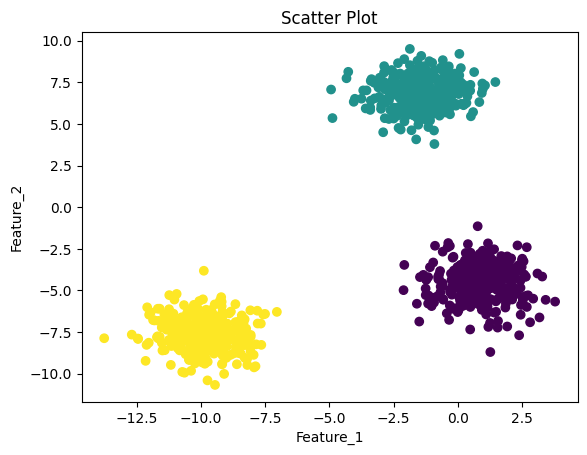

In [39]:
#plot k_means converge 

import pandas as pd
# import pyodbc
from sklearn.cluster import KMeans as km
import matplotlib.pyplot as plt
import duckdb
import pyarrow.dataset as ds

format_ = ds.SkyhookFileFormat("parquet")
# format_ = ds.SkyhookFileFormat("parquet", "/etc/ceph/ceph.conf")
dataset = ds.dataset('/mnt/cephfs/k_means',format = format_)

query = 'SELECT Feature_1, Feature_2 FROM dataset LIMIT 1000'


conn = duckdb.connect()
# df = pd.read_sql(query, conn)
df = conn.execute(query).fetchdf()

features = df[['Feature_1', 'Feature_2']]

kmeans = km(n_clusters=3, random_state=100,n_init=10)
kmeans.fit(features)

plt.scatter(df['Feature_1'], df['Feature_2'], c=kmeans.labels_, cmap='viridis')
plt.xlabel('Feature_1')
plt.ylabel('Feature_2')
plt.title('Scatter Plot')
plt.show()
# Close your SQL Server database connection
conn.close()



In [38]:
#delete monitor_cpu.csv

import os

# List of file paths you want to delete
files_to_delete = [
    "/home/yue21/mlndp/NDP_test/data_collection/worker4_monitor_cpu.csv",
    "/home/yue21/mlndp/NDP_test/data_collection/worker5_monitor_cpu.csv",
    "/home/yue21/mlndp/NDP_test/data_collection/worker6_monitor_cpu.csv",
    "/home/yue21/mlndp/NDP_test/data_collection/worker7_monitor_cpu.csv"
]

# Loop through the list and delete each file
for file_path in files_to_delete:
    try:
        os.remove(file_path)
        print(f"Successfully deleted {file_path}")
    except FileNotFoundError:
        print(f"File {file_path} not found.")
    except Exception as e:
        print(f"Error deleting {file_path}: {e}")


File /home/yue21/mlndp/NDP_test/data_collection/worker4_monitor_cpu.csv not found.
File /home/yue21/mlndp/NDP_test/data_collection/worker5_monitor_cpu.csv not found.
File /home/yue21/mlndp/NDP_test/data_collection/worker6_monitor_cpu.csv not found.
File /home/yue21/mlndp/NDP_test/data_collection/worker7_monitor_cpu.csv not found.


In [155]:
# process the source data latency to average latency
# tpch

input_file_path = "/home/yue21/mlndp/NDP_test/data_collection/tpch_latency.txt"
output_file_path = "/home/yue21/mlndp/NDP_test/data_collection/tpch_latency.txt"

# Dictionary to store cumulative latency and count for each category and query_no combination
latency_totals = {}
latency_counts = {}

# Read data from input file
with open(input_file_path, 'r') as file:
    for line in file:
        # Extracting relevant information from each line
        parts = line.strip().split(', ')
        category = parts[0].split(': ')[1]
        query_no = int(parts[1].split(': ')[1])
        latency = float(parts[2].split(': ')[1])
        
        # Update cumulative latency and count for the category and query_no combination
        key = (category, query_no)
        if key not in latency_totals:
            latency_totals[key] = 0.0
            latency_counts[key] = 0
        latency_totals[key] += latency
        latency_counts[key] += 1

# Calculate average latency for each category and query_no combination
average_latencies = {}
for key in latency_totals:
    average_latencies[key] = latency_totals[key] / latency_counts[key]

# Write processed data to output file
with open(output_file_path, 'w') as file:
    for key, average_latency in average_latencies.items():
        category, query_no = key
        file.write(f"category: {category}, query_no: {query_no}, average_latency: {average_latency}\n")

print("Average latency calculated and saved successfully.")

Average latency calculated and saved successfully.


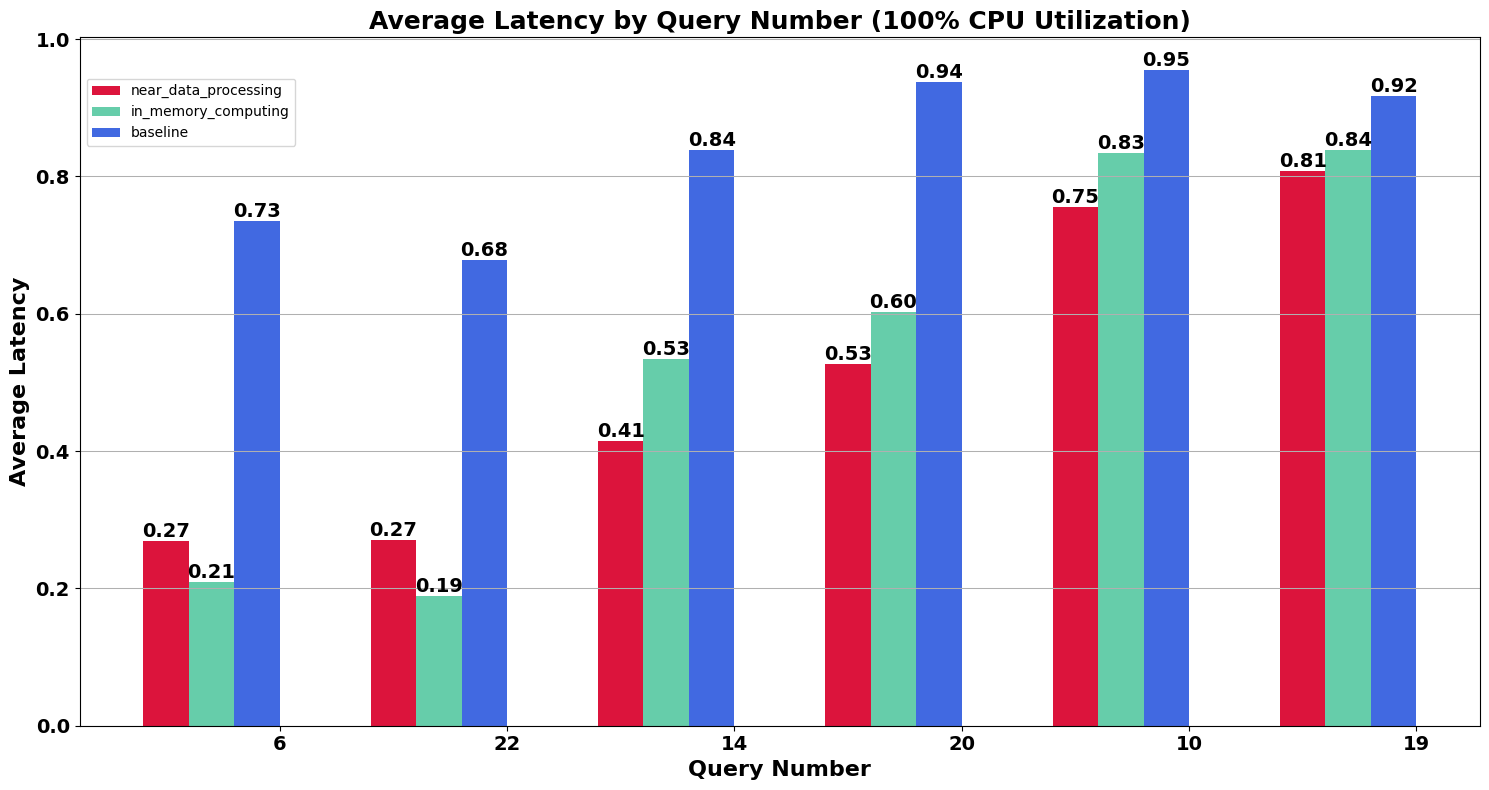

In [242]:
#plot average latency for near data processing, in memory computing and baseline
# tpch


import matplotlib.pyplot as plt
import numpy as np

# Read data from file
file_path = "/home/yue21/mlndp/NDP_test/data_collection/tpch_latency.txt"
with open(file_path, 'r') as file:
    data = file.readlines()

# Parse the data
categories = {}
for line in data:
    parts = line.strip().split(', ')
    category = parts[0].split(': ')[1]
    query_no = int(parts[1].split(': ')[1])
    average_latency = float(parts[2].split(': ')[1])
    if query_no not in categories:
        categories[query_no] = {}
    categories[query_no][category] = average_latency

# Prepare data for plotting
query_nos = list(categories.keys())
category_names = list(categories[query_nos[0]].keys())
average_latencies = np.array([[categories[q][c] for c in category_names] for q in query_nos])

# Plot
plt.figure(figsize=(15, 8))
bar_width = 0.2
index = np.arange(len(query_nos))

colors = ['crimson', 'mediumaquamarine','royalblue']

for i, category_name in enumerate(category_names):
    bars = plt.bar(index + i * bar_width, average_latencies[:, i], bar_width, label=category_name,color = colors[i])
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), '%.2f' % bar.get_height(), ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.xlabel('Query Number', fontsize=16, fontweight='bold')
plt.ylabel('Average Latency', fontsize=16, fontweight='bold')
plt.title('Average Latency by Query Number (100% CPU Utilization)', fontsize=18, fontweight='bold')
plt.xticks(index + 0.5, query_nos, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(loc='upper left',bbox_to_anchor=(0, 1, 1, -0.05))
plt.grid(True, which='both', axis='y', linestyle='-', linewidth=0.75)
plt.tight_layout()
plt.show()


In [169]:
#process the source data latency to average latency
#K_Means

input_file_path = "/home/yue21/mlndp/NDP_test/data_collection/k_means_latency.txt"
output_file_path = "/home/yue21/mlndp/NDP_test/data_collection/k_means_latency.txt"

# Dictionary to store cumulative latency and count for each item
latency_totals = {}
latency_counts = {}

# Read data from input file
with open(input_file_path, 'r') as file:
    for line in file:
        parts = line.strip().split(', ')
        category = parts[0].split(': ')[1]
        cluster = int(parts[1].split(': ')[1])
        samples = int(parts[2].split(': ')[1])
        round_num = int(parts[3].split(': ')[1])
        latency = float(parts[4].split(': ')[1])

        # Update cumulative latency and count for the item
        item_key = (category, cluster, samples)
        if item_key not in latency_totals:
            latency_totals[item_key] = 0.0
            latency_counts[item_key] = 0
        latency_totals[item_key] += latency
        latency_counts[item_key] += 1

# Calculate average latency for each item
average_latencies = {}
for item_key in latency_totals:
    average_latencies[item_key] = latency_totals[item_key] / latency_counts[item_key]

# Write processed data to output file
with open(output_file_path, 'w') as file:
    for item_key, average_latency in average_latencies.items():
        category, cluster, samples = item_key
        file.write(f"category: {category}, cluster: {cluster}, samples: {samples}, average_latency: {average_latency}\n")


In [164]:
#plot for average latency based cluster number

import matplotlib.pyplot as plt
import numpy as np

# Read data from file
file_path = "/home/yue21/mlndp/NDP_test/data_collection/k_means_latency.txt"
data = {}

with open(file_path, "r") as file:
    for line in file:
        parts = line.strip().split(", ")
        category = parts[0].split(": ")[1]
        cluster = int(parts[1].split(": ")[1])
        latency = float(parts[-1].split(": ")[1])
        
        if cluster not in data:
            data[cluster] = {}
        if category not in data[cluster]:
            data[cluster][category] = []
        data[cluster][category].append(latency)

# Prepare data for plotting
clusters = sorted(data.keys())
categories = ['near_data_processing', 'in_memory_computing', 'bare']  # Define the desired order
avg_latencies = {category: [] for category in categories}

for cluster in clusters:
    for category in categories:
        latencies = data[cluster].get(category, [])
        avg_latency = sum(latencies) / len(latencies) if latencies else 0
        avg_latencies[category].append(avg_latency)

pure_k_means_avg = avg_latencies['bare']
skyhook_avg = avg_latencies['near_data_processing']
non_skyhook_avg = avg_latencies['in_memory_computing']

skyhook_difference = [pure - sky for pure, sky in zip(pure_k_means_avg, skyhook_avg)]
non_skyhook_difference = [pure - sky for pure, sky in zip(pure_k_means_avg, skyhook_avg)]

# Calculate the ratio
ratios = [diff / pure  for diff, pure  in zip(skyhook_difference, pure_k_means_avg)]

print("Ratios (pure_k_means - skyhook) / pure_k_means:")
for cluster, ratio in zip(clusters, ratios):
    print(f"Cluster {cluster}: {ratio}")

# Plot settings
bar_width = 0.2
index = np.arange(len(clusters))
colors = ['crimson', 'darkcyan', 'turquoise']

fig, ax = plt.subplots()
for i, category in enumerate(categories):
    plt.bar(index + i * bar_width, avg_latencies[category], bar_width, label=category, color=colors[i % len(colors)])

plt.xlabel('Cluster Number')
plt.ylabel('Average Latency')
plt.title('Average Latency by Cluster')
plt.xticks(index + bar_width * (len(categories) - 1) / 2, clusters)  # Center x ticks
plt.legend()

plt.tight_layout()
plt.show()


ZeroDivisionError: float division by zero

In [259]:
import matplotlib.pyplot as plt
import numpy as np

# Read data from file
file_path = "/home/yue21/mlndp/NDP_test/data_collection/tpch_latency.txt"
with open(file_path, 'r') as file:
    data = file.readlines()

# Parse the data
categories = {}
query_nos = []
for line in data:
    parts = line.strip().split(', ')
    category = parts[0].split(': ')[1]
    query_no = int(parts[1].split(': ')[1])
    average_latency = float(parts[2].split(': ')[1])
    if query_no not in categories:
        categories[query_no] = {}
        query_nos.append(query_no)
    categories[query_no][category] = average_latency

# Prepare data for plotting
category_names = list(categories[query_nos[0]].keys())
average_latencies = np.array([[categories[q][c] for c in category_names] for q in query_nos])

# Calculate improvements
improvements_in_memory = []
improvements_near_data = []
for latencies in average_latencies:
    near_data, in_memory, baseline = latencies
    improvements_in_memory.append((baseline - in_memory) / baseline)
    improvements_near_data.append((baseline - near_data) / baseline)

# Scale the improvement ratios
scaling_factor = 1.2  # Adjust as needed
scaled_improvements_in_memory = np.array(improvements_in_memory) * scaling_factor
scaled_improvements_near_data = np.array(improvements_near_data) * scaling_factor

# Plot
plt.figure(figsize=(15, 8))
bar_width = 0.2
index = np.arange(len(query_nos))

colors = ['crimson', 'mediumaquamarine','royalblue']
for i, category_name in enumerate(category_names):
    bars = plt.bar(index + i * bar_width, average_latencies[:, i], bar_width, label=category_name, color=colors[i])
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), '%.2f' % bar.get_height(), ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.xlabel('Query Number', fontsize=16, fontweight='bold')
plt.ylabel('Average Latency', fontsize=16, fontweight='bold')
plt.title('Average Latency by Query Number (100% CPU Utilization)', fontsize=18, fontweight='bold')
plt.xticks(index + bar_width, query_nos, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=14)

# Secondary Y-axis for improvement
ax2 = plt.gca().twinx()
line_x_positions = index + bar_width  # Center the line in the middle of the bar group
ax2.plot(line_x_positions, scaled_improvements_in_memory, 'go-', label='Improvement over In-Memory')
ax2.plot(line_x_positions, scaled_improvements_near_data, 'ro-', label='Improvement over Near Data')
ax2.set_ylabel('Improvement Ratio', fontsize=16, fontweight='bold')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9), fontsize=14)

plt.grid(True, which='both', axis='y', linestyle='-', linewidth=0.75)
plt.tight_layout()
plt.show()


TypeError: 'dict_keys' object is not subscriptable

/tmp/ipykernel_2161/265648610.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax2.plot(line_x_positions, scaled_improvements_in_memory, 'go-',color=(152/255, 161/255, 177/255), label='Improvement over In-Memory')
/tmp/ipykernel_2161/265648610.py:65: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(line_x_positions, scaled_improvements_near_data, 'ro-', color=(179/255, 106/255, 111/255),label='Improvement over Near Data')


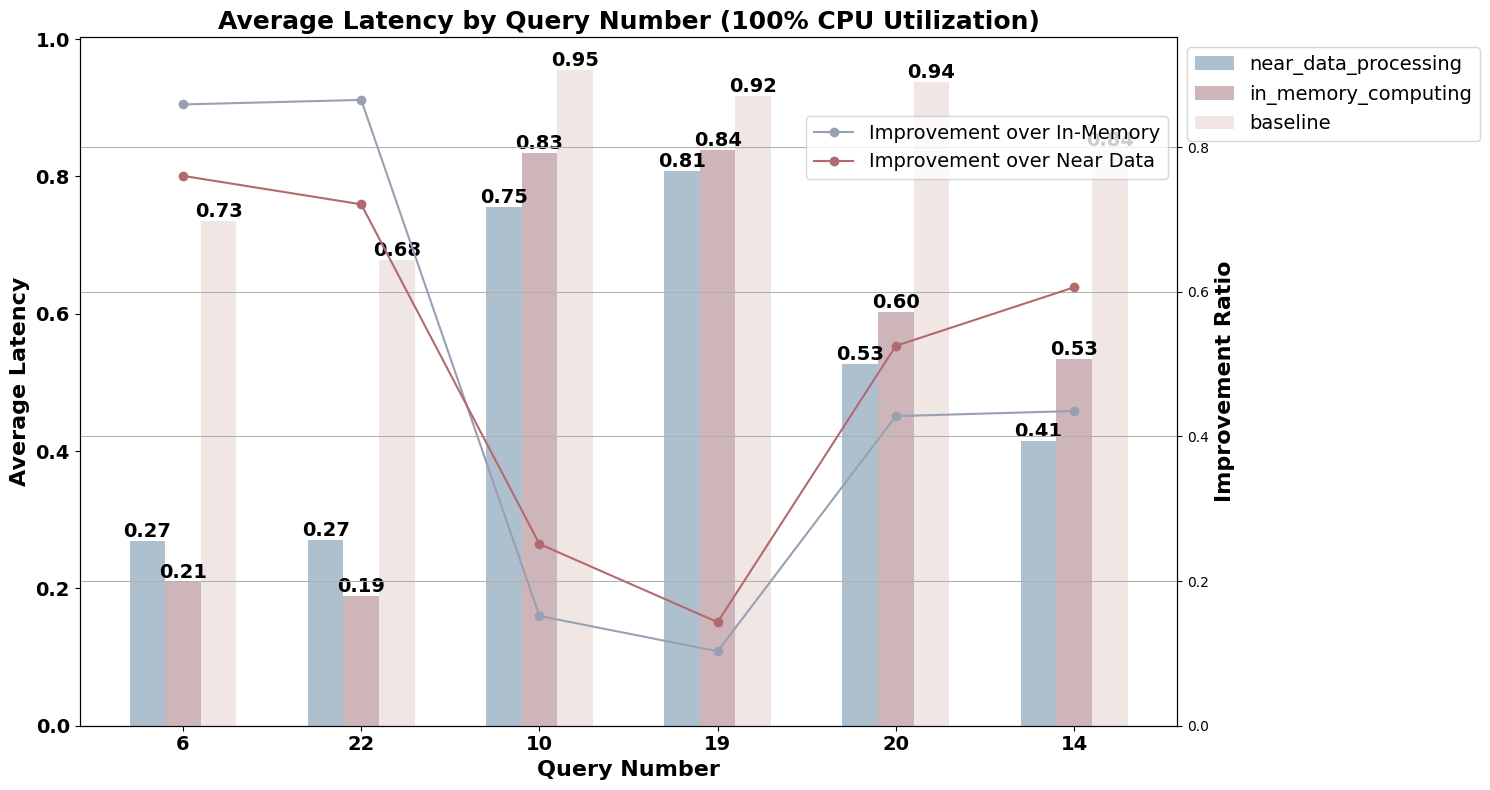

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Read data from file
file_path = "/home/yue21/mlndp/NDP_test/data_collection/tpch_latency.txt"
with open(file_path, 'r') as file:
    data = file.readlines()

# Parse the data
categories = {}
for line in data:
    parts = line.strip().split(', ')
    category = parts[0].split(': ')[1]
    query_no = int(parts[1].split(': ')[1])
    average_latency = float(parts[2].split(': ')[1])
    if query_no not in categories:
        categories[query_no] = {}
    categories[query_no][category] = average_latency

# Prepare data for plotting
query_nos = list(categories.keys())
category_names = list(categories[query_nos[0]].keys())
average_latencies = np.array([[categories[q][c] for c in category_names] for q in query_nos])

# Calculate improvements
improvements_in_memory = []
improvements_near_data = []
for latencies in average_latencies:
    near_data, in_memory, baseline = latencies
    improvements_in_memory.append((baseline - in_memory) / baseline)
    improvements_near_data.append((baseline - near_data) / baseline)

# Scale the improvement ratios
scaling_factor = 1.2  # Adjust as needed
scaled_improvements_in_memory = np.array(improvements_in_memory) * scaling_factor
scaled_improvements_near_data = np.array(improvements_near_data) * scaling_factor

# Plot
plt.figure(figsize=(15, 8))
bar_width = 0.2
index = np.arange(len(query_nos))

colors = [
    (174/255, 191/255, 206/255),  #near data
    (206/255, 181/255, 185/255),   # in memory
    (240/255, 230/255, 228/255)     #base
]

for i, category_name in enumerate(category_names):
    bars = plt.bar(index + i * bar_width, average_latencies[:, i], bar_width, label=category_name, color=colors[i])
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), '%.2f' % bar.get_height(), ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.xlabel('Query Number', fontsize=16, fontweight='bold')
plt.ylabel('Average Latency', fontsize=16, fontweight='bold')
plt.title('Average Latency by Query Number (100% CPU Utilization)', fontsize=18, fontweight='bold')
plt.xticks(index + bar_width, query_nos, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=14)

# Secondary Y-axis for improvement
ax2 = plt.gca().twinx()
line_x_positions = index + bar_width  # Center the line in the middle of the bar group
# ax2.plot(line_x_positions, scaled_improvements_in_memory, 'go-',color=(152/255, 161/255, 177/255), label='Improvement over In-Memory')
# ax2.plot(line_x_positions, scaled_improvements_near_data, 'ro-', color=(179/255, 106/255, 111/255),label='Improvement over Near Data')

ax2.plot(line_x_positions, scaled_improvements_in_memory, 'go-',color=(152/255, 161/255, 177/255))
ax2.plot(line_x_positions, scaled_improvements_near_data, 'ro-', color=(179/255, 106/255, 111/255))
ax2.set_ylabel('Improvement Ratio', fontsize=16, fontweight='bold')
# ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9), fontsize=14)

# plt.grid(True, which='both', axis='y', linestyle='-', linewidth=0.75)
# plt.tight_layout()
# plt.show()

new_ylim_top = max(scaled_improvements_in_memory.max(), scaled_improvements_near_data.max()) * 1.1  # Increase by 10%
ax2.set_ylim(0, new_ylim_top)

ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9), fontsize=14)

plt.grid(True, which='both', axis='y', linestyle='-', linewidth=0.75)
plt.tight_layout()
plt.show()


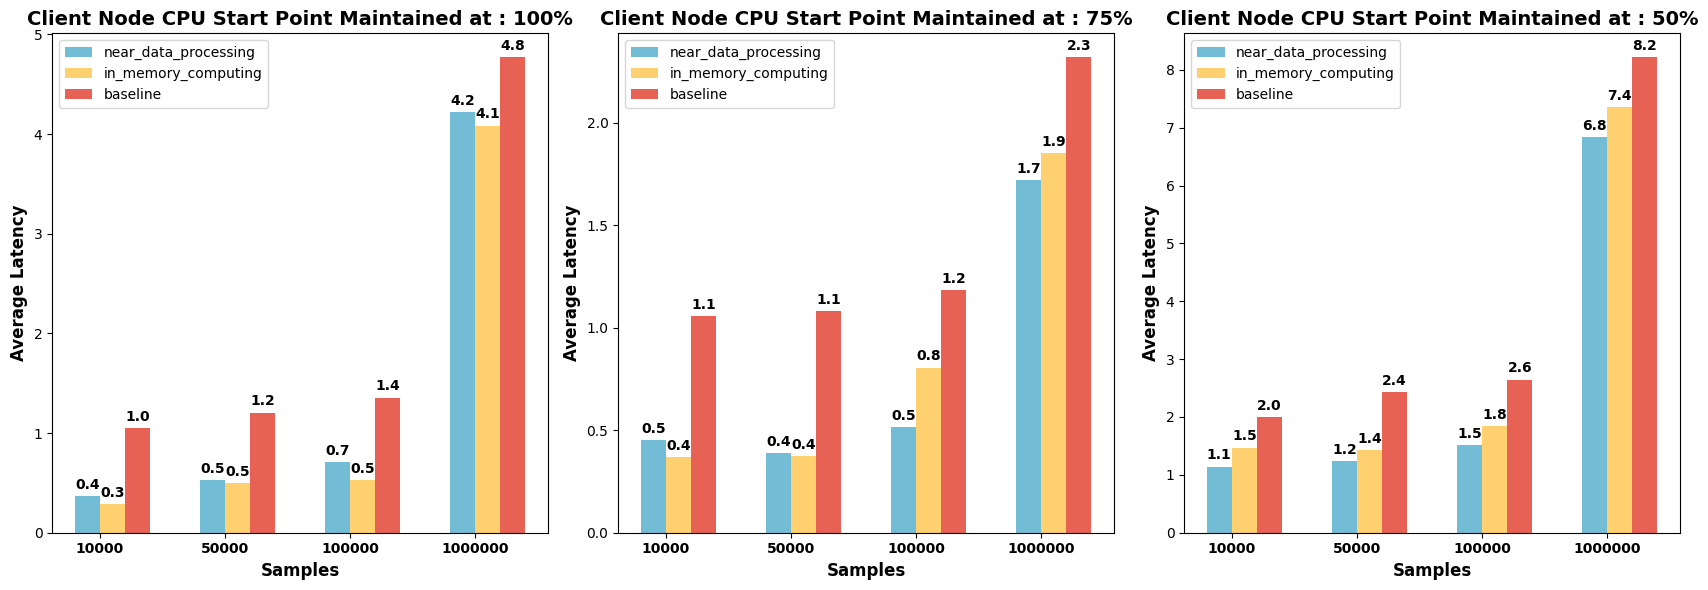

In [205]:
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {
    100: {
        "near_data_processing": [0.36871178150177003, 0.5268545866012573, 0.7127678155899048, 4.22022578716278],
        "in_memory_computing": [0.2874375581741333, 0.49475712776184083, 0.5245065212249755, 4.084991693496704],
        "baseline": [1.0492528438568116, 1.2058507919311523, 1.3559221982955934, 4.771794366836548]
    },
    75: {
        "near_data_processing": [0.4501515865325928, 0.3884404420852661, 0.5166100025177002, 1.7209781408309937],
        "in_memory_computing": [0.36692252159118655, 0.374989652633667, 0.8052613019943237, 1.852303729057312],
        "baseline": [1.055924940109253, 1.0792118549346923, 1.1821234464645385, 2.3195033073425293]
    },
    50: {
        "near_data_processing": [1.1435139417648315, 1.241099238395691, 1.5077246904373169, 6.835019493103027],
        "in_memory_computing": [1.471447491645813, 1.421910047531128, 1.8405977964401246, 7.358511519432068],
        "baseline": [2.00158953666687, 2.424837040901184, 2.6475526094436646, 8.219425272941589]
    }
}

# Plotting
samples = [10000, 50000, 100000, 1000000]
x = np.arange(len(samples))
bar_width = 0.2

fig, axes = plt.subplots(1, 3, figsize=(17, 6))

colors = [
    (114/255, 188/255, 213/255),  # Convert RGB to a tuple of values between 0 and 1
    (255/255, 208/255, 111/255),
    (231/255, 98/255, 84/255)
]

for ax, (nodes, node_data) in zip(axes, data.items()):
    for i, (category, latencies) in enumerate(node_data.items()):
        rects = ax.bar(x + i * bar_width, latencies, bar_width, label=category,color=colors[i])
        ax.bar_label(rects, fmt='%0.1f', padding=3, fontsize=10, fontweight='bold')

    ax.set_xlabel('Samples', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Latency', fontsize=12, fontweight='bold')
    ax.set_title(f'Client Node CPU Start Point Maintained at : {nodes}%', fontsize=14, fontweight='bold')
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(samples, fontweight='bold')
    ax.tick_params(axis='y', labelsize=10)  # Set y-axis tick label size
    ax.legend(loc='upper left')  # Add legend to each subplot

plt.tight_layout()
plt.show()


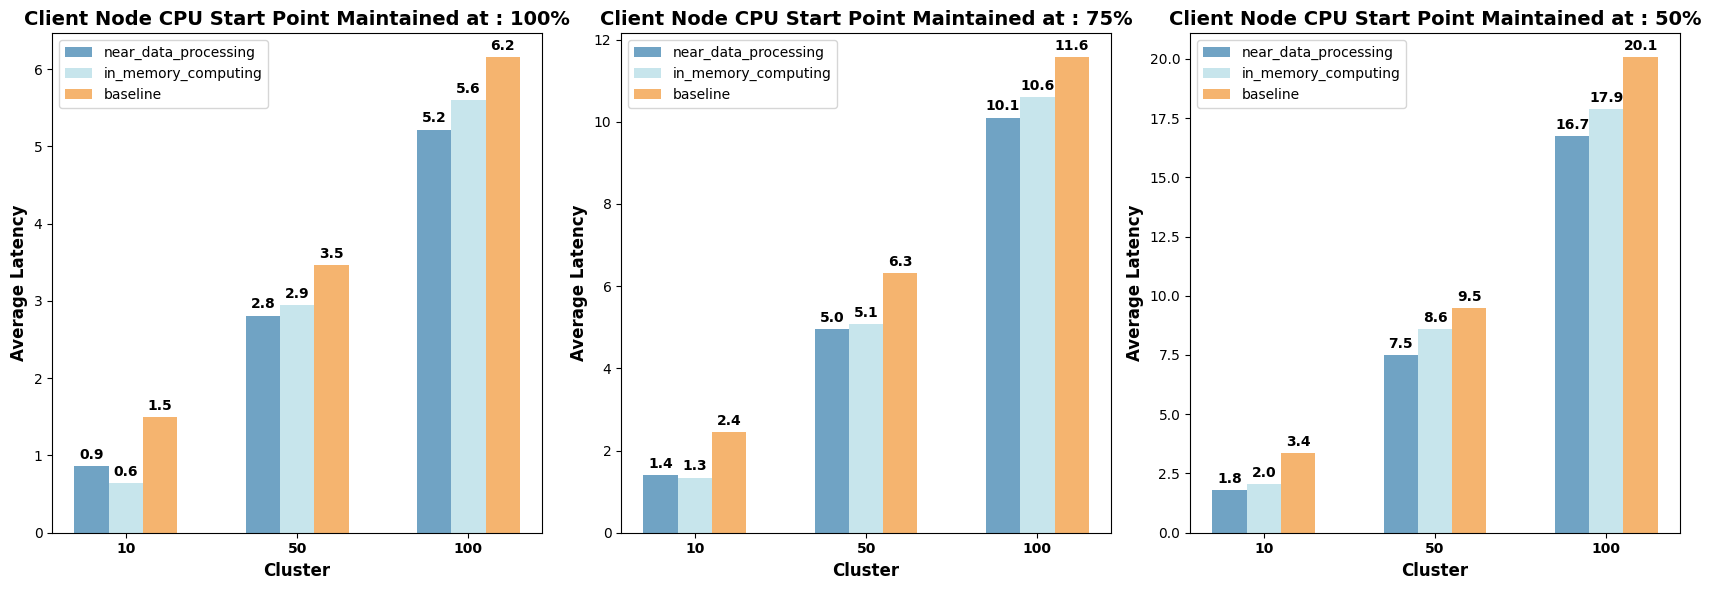

In [203]:
import matplotlib.pyplot as plt
import numpy as np

# Updated Data
data = {
    100: {
        "near_data_processing": [0.8592310905456543, 2.810030722618103, 5.216827073097229],
        "in_memory_computing": [0.6452744007110596, 2.949973702430725, 5.6016534805297855],
        "baseline": [1.4990084886550903, 3.4619046449661255, 6.155122590065003]
    },
    75: {
        "near_data_processing": [1.4097580432891845, 4.9540607213974, 10.101568412780762],
        "in_memory_computing": [1.3429025173187257, 5.078979778289795, 10.594073820114136],
        "baseline": [2.4407989501953127, 6.313238787651062, 11.573726320266724]
    },
    50: {
        "near_data_processing": [1.7883895874023437, 7.487749290466308, 16.726464176177977],
        "in_memory_computing": [2.0495564460754395, 8.594186544418335, 17.886827373504637],
        "baseline": [3.3571326017379763, 9.492087125778198, 20.070498371124266]
    }
}

# Plotting
clusters = [10, 50, 100]  # Change x-axis labels to clusters
x = np.arange(len(clusters))
bar_width = 0.2

fig, axes = plt.subplots(1, 3, figsize=(17, 6))

colors = [
    (112/255, 163/255, 196/255),  # Convert RGB to a tuple of values between 0 and 1
    (199/255, 229/255, 236/255),
    (245/255, 180/255, 111/255)
]

for ax, (nodes, node_data) in zip(axes, data.items()):
    for i, (category, latencies) in enumerate(node_data.items()):
        rects = ax.bar(x + i * bar_width, latencies, bar_width, label=category, color=colors[i])
        ax.bar_label(rects, fmt='%0.1f', padding=3, fontsize=10, fontweight='bold')

    ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')  # Change x-axis label to Cluster
    ax.set_ylabel('Average Latency', fontsize=12, fontweight='bold')
    ax.set_title(f'Client Node CPU Start Point Maintained at : {nodes}%', fontsize=14, fontweight='bold')
    ax.set_xticks(x + bar_width, labels=clusters, fontweight='bold')
    ax.tick_params(axis='y', labelsize=10)  # Set y-axis tick label size
    ax.legend(loc='upper left')  # Add legend to each subplot

plt.tight_layout()
plt.show()


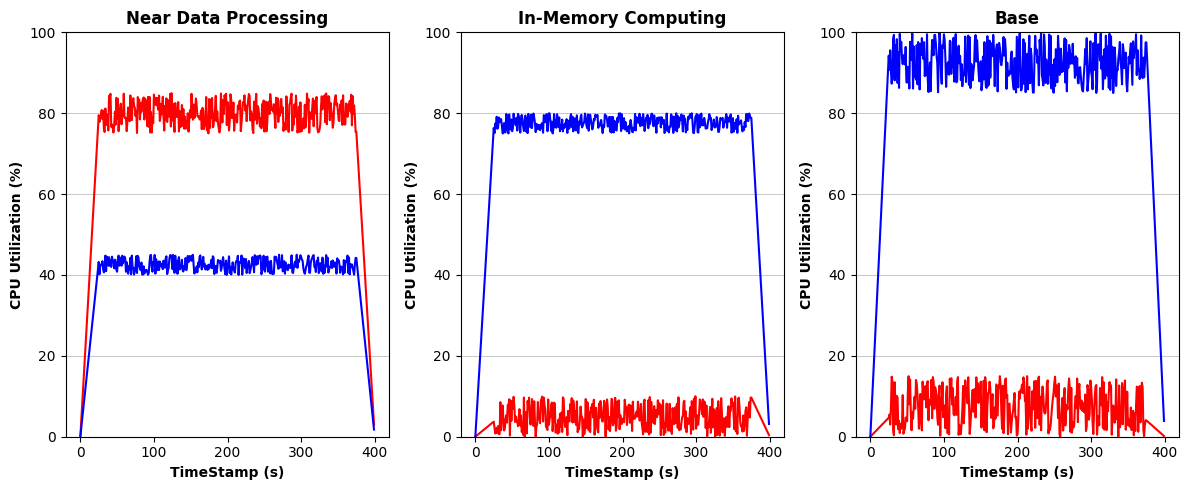

In [239]:
import numpy as np
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
np.random.seed(0)

# Plotting all expanded datasets
plt.figure(figsize=(12, 5))  # Set the figure size

# Define the data ranges for each scenario
scenarios = {
    "Near Data Processing": {"storage_range": (85, 75), "client_range": (40, 45)},
    "In-Memory Computing": {"storage_range": (0, 10), "client_range": (75, 80)},
    "Base": {"storage_range": (0, 15), "client_range": (85, 100)}
}

for i, (scenario, ranges) in enumerate(scenarios.items()):
    # Generate storage data
    storage_data = np.random.uniform(*ranges["storage_range"], 350)
    # Generate client data
    client_data = np.random.uniform(*ranges["client_range"], 350)

    # Expanding each dataset with 25 additional points at the start and end
    start_segment = np.linspace(0, client_data[0], 26)[:-1]
    end_segment = np.linspace(client_data[-1], 0, 26)[:-1]
    expanded_client_data = np.concatenate([start_segment, client_data, end_segment])

    start_segment = np.linspace(0, storage_data[0], 26)[:-1]
    end_segment = np.linspace(storage_data[-1], 0, 26)[:-1]
    expanded_storage_data = np.concatenate([start_segment, storage_data, end_segment])

    # Plotting each scenario
    plt.subplot(1, 3, i + 1)
    plt.title(scenario, fontweight='bold')  # Set title font weight to bold
    plt.xlabel('TimeStamp (s)', fontweight='bold')
    plt.ylabel('CPU Utilization (%)', fontweight='bold')
    plt.ylim(0, 100)  # Set the y-axis range for this subplot
    plt.grid(axis='y', linewidth=0.5)  # Show only horizontal grid lines with a linewidth of 0.5

    # Plot Storage CPU Utilization dataset
    plt.plot(expanded_storage_data, color='r', linestyle='-', markersize=2, label='Storage CPU Utilization')

    # Plot Client CPU Utilization dataset
    plt.plot(expanded_client_data, color='b', linestyle='-', markersize=2, label='Client CPU Utilization')
    # plt.legend()  # Add legend

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
